# Data Loading

In [3]:
#mounting google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Import Libraries

In [4]:
# import all necessary libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


Load data set as excel file

In [8]:
file_path='/content/drive/MyDrive/Refactory Work/literacy_rates_updated.xlsx'
df=pd.read_excel(file_path)
df.head() #diplsay the first few rows to see what the data looks like

,Region,Country,Year,Age,Gender,Literacy rate
0,Central and Southern Asia,Afghanistan,2011,<15,female,0.176121
1,Central and Southern Asia,Afghanistan,2011,<15,male,0.454171
2,NaN,Afghanistan,2011,15-24,female,0.321132
3,NaN,Afghanistan,2011,15-24,male,0.618791
4,Central and Southern Asia,Afghanistan,2011,25-64,female,0.084128


#Data Inspection

In [9]:
df.info() #show how many rows, columns and each column's data type

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3313 entries, 0 to 3312
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Region         3309 non-null   object 
 1   Country        3313 non-null   object 
 2   Year           3313 non-null   object 
 3   Age            3313 non-null   object 
 4   Gender         3313 non-null   object 
 5   Literacy rate  3308 non-null   float64
dtypes: float64(1), object(5)
memory usage: 155.4+ KB


In [11]:
# Check unique Column names to see if there are inconsistencies like mispellings, case variations, extra characters, inconsistencies in naming and others.
print("\n Unique Regions: \n", df["Region"].unique())

print("\n Unique Countries: \n", df["Country"].unique())

print("\n Unique Ages: \n", df["Age"].unique())

print("\n Unique Genders: \n", df["Gender"].unique())


 Unique Regions:
 ['Central and Southern Asia' nan 'Eastern and South-Eastern Asia'
 'Europe and Northern America' 'Latin America and the Caribbean'
 'Northern Africa and Western Asia' 'Oceania' 'Sub-Saharan Africa']

 Unique Countries:
 ['Afghanistan' 'Bangladesh' 'Bhutan' 'India' 'Iran (Islamic Republic of)'
 'Kazakhstan' 'Kyrgyzstan' 'Maldives' 'Nepal' 'Pakistan' 'Sri Lanka'
 'Tajikistan' 'Turkmenistan' 'Uzbekistan' 'Brunei Darussalam' 'Cambodia'
 'China' 'China, Macao Special Administrative Region' 'Indonesia'
 "Lao People's Democratic Republic" 'Malaysia' 'Mongolia' 'Myanmar'
 'Philippines' 'Singapore' 'Thailand' 'Timor-Leste' 'Viet Nam' 'Albania'
 'Belarus' 'Bosnia and Herzegovina' 'Bulgaria' 'Croatia' 'Estonia'
 'Greece' 'Hungary' 'Italy' 'Latvia' 'Lithuania' 'Malta' 'Montenegro'
 'Portugal' 'Republic of Moldova' 'Romania' 'Russian Federation'
 'San Marino' 'Serbia' 'Slovenia' 'Spain'
 'The former Yugoslav Republic of Macedonia' 'Ukraine'
 'Antigua and Barbuda' 'Argentina' 'Aru

# Data Cleaning


**Addressing inconsistencies**

In [19]:
string_cols_to_strip=['Region','Country', 'Age', 'Gender'] #columns to strip
for col in string_cols_to_strip:
  if df[col].dtype == 'object': #ensuring only string columns are captured to avoid errors on non-string columns
    df[col]=df[col].str.strip()

#Gender
#lowercasing all Gender values to make them consistent.
df["Gender"] = df["Gender"].str.lower()

# Replacing any known short forms with the proper full word.
df["Gender"] = df["Gender"].replace({"m": "male", "f": "female"})

# Checking Gender values again to confirm they look good.
print(df["Gender"].unique())


['female' 'male']


**Addressing Duplicate Rows**

In [20]:
# Finding total number of duplicate rows
print("Number of duplicate rows:", df.duplicated().sum())

# Removing any duplicate rows found.
df = df.drop_duplicates()

# Checking again to make sure duplicates are gone.
print("Number of duplicate rows after dropping:", df.duplicated().sum())


Number of duplicate rows: 10
Number of duplicate rows after dropping: 0


**Correcting Data types**

In [23]:

# If there's a bad value (like text), convert it to NaN, then to nullable Int64.
df["Year"] = pd.to_numeric(df["Year"], errors="coerce").astype("Int64")

# Make sure Literacy rate has no percent signs, then convert to float.
df["Literacy rate"] = df["Literacy rate"].astype(str).str.replace("%", "")

# Convert to numeric; bad values become NaN.
df["Literacy rate"] = pd.to_numeric(df["Literacy rate"], errors="coerce")

# If any Literacy rate is bigger than 1, assume it's a percent written wrong, so divide by 100.
df.loc[df["Literacy rate"] > 1, "Literacy rate"] /= 100


**Addressing identified missing values with suitable placeholders.**

The identified columns with missing values are the Region and Literacy Rate columns.

Missing Region names were filled using other available country data, or 'Unknown' if no country data was found. Missing Literacy rates were then realistically filled using the median rate for each specific region.
The year column was also sorted to make the filling logical in time order, so the Region is pulled from the closest valid record.

In [24]:
# Sorting by Country and Year so that related rows are together and .ffill() and .bfill() work correctly.
df = df.sort_values(["Country", "Year"])

#Grouping by Country. fills region downward & upward within each country
df["Region"] = df.groupby("Country")["Region"].ffill()
df["Region"] = df.groupby("Country")["Region"].bfill()

#Filling any still missing region with 'Unknown'
df["Region"] = df["Region"].fillna("Unknown")

# Filling missing Literacy rate with regional median
regional_median = df.groupby("Region")["Literacy rate"].transform("median") #creating a temporary series of regional_median
df["Literacy rate"] = df["Literacy rate"].fillna(regional_median)

# If any Literacy rate still missing, use global median
global_median = df["Literacy rate"].median(skipna=True) #median across the whole column
df["Literacy rate"] = df["Literacy rate"].fillna(global_median)

#Checking how many missing values still exist in just the Region and Literacy rate columns
print(df[["Region", "Literacy rate"]].isnull().sum())



Region           0
Literacy rate    0
dtype: int64


Identifing unusal Data points
Focusing on the Literacy rate since it is the only numeric value that must be within a strict range (0 to 1).

In [29]:
# Look for rows where Literacy rate is -1 (our placeholder for missing).
print("Rows with missing Literacy rate (flagged as -1):")
print(df[df["Literacy rate"] < 0])

# Look for any Literacy rates still above 1 (shouldn't happen, but good to double-check).
print("Rows with Literacy rate > 1 (should be none):")
print(df[df["Literacy rate"] > 1])

# Look at the cleaned data sample.
df.head()


Rows with missing Literacy rate (flagged as -1):
Empty DataFrame
Columns: [Region, Country, Year, Age, Gender, Literacy rate]
Index: []
Rows with Literacy rate > 1 (should be none):
Empty DataFrame
Columns: [Region, Country, Year, Age, Gender, Literacy rate]
Index: []


,Region,Country,Year,Age,Gender,Literacy rate
0,Central and Southern Asia,Afghanistan,2011,<15,female,0.176121
1,Central and Southern Asia,Afghanistan,2011,<15,male,0.454171
2,Central and Southern Asia,Afghanistan,2011,15-24,female,0.321132
3,Central and Southern Asia,Afghanistan,2011,15-24,male,0.618791
4,Central and Southern Asia,Afghanistan,2011,25-64,female,0.084128


Save the cleaned data

In [33]:
# Save the cleaned dataset as a new CSV file for later use or sharing.
df.to_csv("cleaned_literacy_data.csv", index=False)


# Data Exploration

##  UNIVARIATE EXPLORATION

**Literacy Rate Distribution**

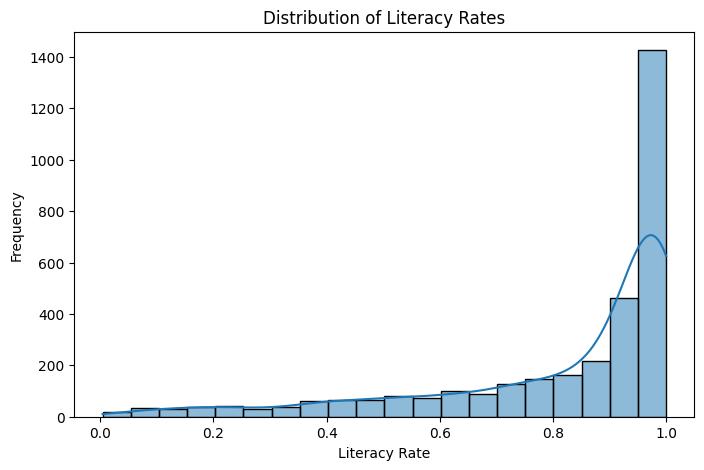

In [30]:
# Plotting histogram for Literacy rates.
plt.figure(figsize=(8,5))

# Using only valid literacy rates
sns.histplot(df[df["Literacy rate"] >= 0]["Literacy rate"], bins=20, kde=True)
plt.title("Distribution of Literacy Rates")
plt.xlabel("Literacy Rate")
plt.ylabel("Frequency")
plt.show()

This shows how literacy rates spread across the data.
Most literacy rates are high, ranging between 0.7 to 1.0 (70–100%), peakign at 1.0. This means that high literacy rates are much more common in this data set.
The graph shows a tail on the left, meaning some countries and regions still have low literacy. This is where the non-profit should focus.



**Age Group Counts**


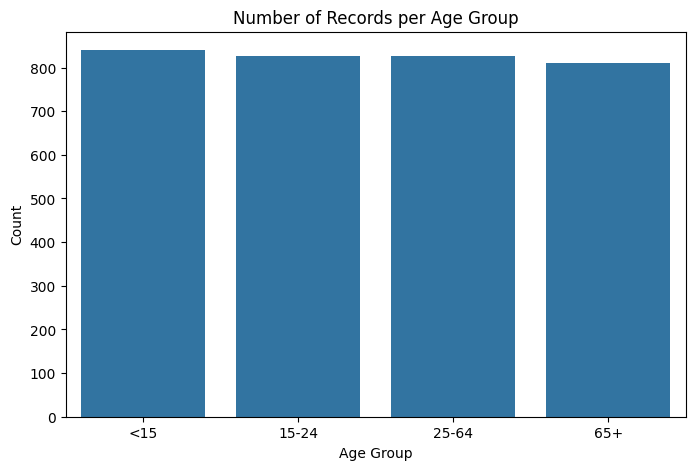

In [31]:
# Plotting how many records there are for each age group.
plt.figure(figsize=(8,5))

# Using countplot to show counts per age group.
sns.countplot(data=df, x="Age", order=["<15", "15-24", "25-64", "65+"])

plt.title("Number of Records per Age Group")
plt.xlabel("Age Group")
plt.ylabel("Count")
plt.show()

This shows which age groups have more data.
It also shows which age groups might need more data or attention.
According to the bars, the "25-64" age group has the highest average literacy rate. The "65+" age group has a lower average literacy rate. This means that the older populations tend to have lower literacy rates in this dataset.

# MULTIVARIATE EXPLORATION

**Boxplot: Literacy by Gender**

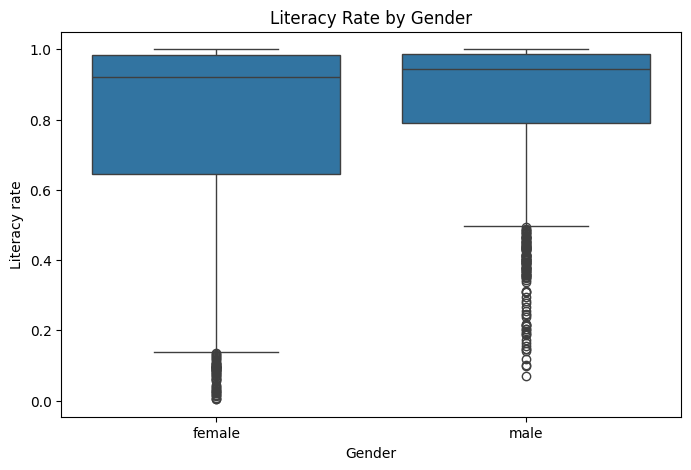

In [27]:
# Comparing Literacy rate distribution between males and females.
plt.figure(figsize=(8,5))

# Using boxplot to see median and spread.
sns.boxplot(data=df[df["Literacy rate"] >= 0], x="Gender", y="Literacy rate")

plt.title("Literacy Rate by Gender")
plt.show()


This compares the literacy levels of the females versus the males and so shows if there's a gender gap.
On average, females have a slightly lower literacy rate compared to males. The difference appears small but consistent.
The nonprofit might target programs for the female group but maintain the programs for the male group since the gap is not so big.


**Lineplot: Literacy over Time by Gender**

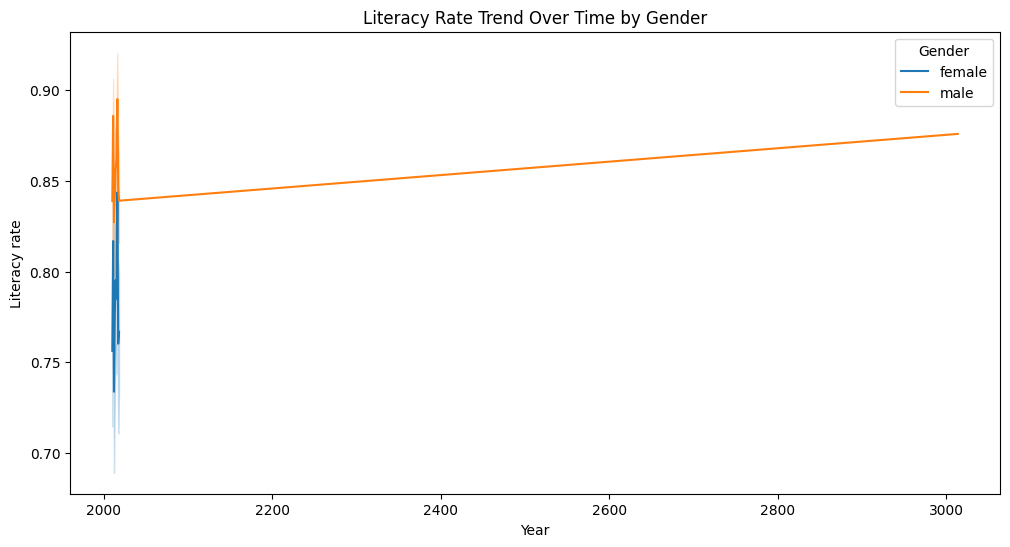

In [28]:
# Seeing trends over time for each gender.
plt.figure(figsize=(12,6))

# Using lineplot to show how Literacy rate changes by Year and Gender.
sns.lineplot(data=df[df["Literacy rate"] >= 0], x="Year", y="Literacy rate", hue="Gender")

plt.title("Literacy Rate Trend Over Time by Gender")
plt.show()

This shows if literacy is improving over time and if gender gaps are closing or staying the same as wella s the projected trend.
Around 2000, there seems to have been a significant gap with the female literacy rates being significantly lower than their male counterparts.

Over time, the male literacy rate shows a steady and gradual increase.
The female literacy rate shows a more dramatic increase around 2000, but remains below the male literacy rate thorughout the observed period.

The graph shows a positive outlook for both genders but also a consistent gap where the female rates are consistently lower than the male rates.

# Conclusion
Based on this data analysis, most countries in the dataset have high literacy rates, crowded towards 100%.

However, literacy rates vary noticeably by region, with Europe and Northern America showing the highest rates, while Sub-Saharan Africa and Central and Southern Asia generally have lower average literacy rates. There is also a significant gender gap in literacy rates.

Although the overall youth literacy is generally high, in many regions especially parts of Sub-Saharan Africa and Central/Southern Asia, there still exist low literacy rates and significant gender gaps disadvantaging the girls. The non-profit should focus its next efforts and projects on these low-literacy regions and design programs that target young girls while leveraging community engagement to enable them complete their education.
